# New Model
More complex GAN using ResNet units.

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import PIL
import cv2

import os, os.path
from abc import ABC, abstractmethod


use_cuda=True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Loading


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile
# import urllib.request
file_name = "drive/My Drive/University/APS360/APS360 Final Project/dataset.zip"
# urllib.request.urlretrieve(url, file_name)
ZipFile(file_name).extractall()

In [0]:
# Real dir: 'whatever/', the ending / is important
class EdgeRealDataset(torch.utils.data.Dataset):
    def __init__(self, real_dir, edge_dir, transform = None):
        self.real_dir = real_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.count = len([n for n in os.listdir(real_dir) if os.path.isfile(real_dir + n)])
    
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        real_img = cv2.imread(self.real_dir+str(idx)+'.png')
        real_img = cv2.cvtColor(real_img, cv2.COLOR_BGRA2RGBA) # test if the actual
        
        edge_img = cv2.imread(self.edge_dir+str(idx)+'.png')
        edge_img = cv2.cvtColor(edge_img, cv2.COLOR_BGRA2RGBA) # test if the actual
        
        if self.transform:
            real_img = self.transform(real_img)
            edge_img = self.transform(edge_img)
        
        return (real_img, edge_img)

In [5]:
transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))         
         ])
train_data_set = EdgeRealDataset('./train_processed/trousers/filtered/', './train_processed/trousers/whites/', transform=transform)
print("Number of training data points is {}".format(len(train_data_set)))
val_data_set = EdgeRealDataset('./validation_processed/trousers/filtered/', './validation_processed/trousers/whites/', transform=transform)
print("Number of validation data points is {}".format(len(val_data_set)))


Number of training data points is 4320
Number of validation data points is 661


In [6]:
train_data_set += EdgeRealDataset('./train_processed/long sleeve top/filtered/', './train_processed/long sleeve top/whites/', transform=transform)
print("Number of training data points is {}".format(len(train_data_set)))
val_data_set += EdgeRealDataset('./validation_processed/long sleeve top/filtered/', './validation_processed/long sleeve top/whites/', transform=transform)
print("Number of validation data points is {}".format(len(val_data_set)))

Number of training data points is 5987
Number of validation data points is 932


In [7]:
train_data_set += EdgeRealDataset('./train_processed/short sleeve top/filtered/', './train_processed/short sleeve top/whites/', transform=transform)
print("Number of training data points is {}".format(len(train_data_set)))
val_data_set += EdgeRealDataset('./validation_processed/short sleeve top/filtered/', './validation_processed/short sleeve top/whites/', transform=transform)
print("Number of validation data points is {}".format(len(val_data_set)))

Number of training data points is 9087
Number of validation data points is 1549


In [0]:
def get_data_loader(data_set, batch_size, data_samples = -1, shuffle=False):
    """ Generates training, validation and testing data loader for the relevant 
    target classes for a given batch size.

    Args:
        full_data_set: Dataset object containing data points to be split into 
                        training, validation and test put into data loaders
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: size per batch
        data_samples: integer number of data samples to use, defaults to -1 to use all
                      data points
    Returns:
        training, validation and testing data loaders with a distribution of 
        60:30:10
    """
  
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    torch.manual_seed(1000)

    # dataset = EdgeRealDataset(full_data_set)

    num_samples = len(data_set)

    # To do: Randomize indices list and set number of data samples if we want a smaller data set
    # Randomize indices list
    indices = list(range(num_samples))
    np.random.shuffle(indices)
    if data_samples != -1:
      indices = indices[:data_samples]

    sampler = SubsetRandomSampler(indices)

    loader = DataLoader(data_set, batch_size=batch_size,
                                num_workers=1, sampler=sampler)
    
    return loader

In [0]:
train_loader = get_data_loader(train_data_set, 1, 1000, shuffle=True)
val_loader = get_data_loader(val_data_set, 1)

In [10]:
len(train_loader)

1000

Visualize data samples

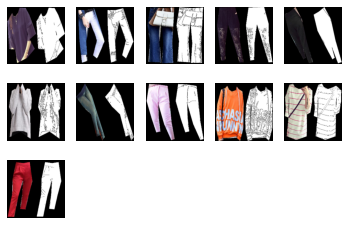

In [11]:
k = 0
for reals, edges in train_loader:
  # since batch_size = 1, there is only 1 image in `images`
  # print(image[0:3].shape)
  # noise = np.random.uniform(-0.25, 0.25, size=edges[0][0:3].shape)
  # noise = torch.from_numpy(noise).float()
  # edges[0][0:3] += noise
  # edges[0][0:3] = (edges[0][0:3]+0.25)/1.5

  image = torch.cat((reals[0], edges[0]), 2)
  
  # image[] /= 2
  # image += 1
  #image = edges[0]
  # place the colour channel at the end, instead of at the beginning
  img = np.transpose(image, [1,2,0])
  # normalize pixel intensity values to [0, 1]
  img = img / 2 + 0.5
  plt.subplot(3, 5, k+1)
  plt.axis('off')
  plt.imshow(img)

  k += 1
  if k > 10:
    break

# ResNet Model Code

## RESNET Generator


https://freecontent.manning.com/pytorch-crash-course-part-3/

In [0]:
class ResNetBlock(nn.Module):
  
     def __init__(self, dim):
         super(ResNetBlock, self).__init__()
         self.conv_block = self.build_conv_block(dim)
  
     def build_conv_block(self, dim):
         conv_block = []
  
         conv_block += [nn.ReflectionPad2d(1)]
  
         conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                        nn.InstanceNorm2d(dim),
                        nn.ReLU(True)]
  
         conv_block += [nn.ReflectionPad2d(1)]
  
         conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                        nn.InstanceNorm2d(dim)]
  
         return nn.Sequential(*conv_block)
  
     def forward(self, x):
         out = x + self.conv_block(x)
         return out
  
  
class ResNetGenerator(nn.Module):
  
  def __init__(self, name="gen", input_nc=3, output_nc=3, ngf=64, n_blocks=9):
  
    super(ResNetGenerator, self).__init__()
    self.name = name
    self.input_nc = input_nc
    self.output_nc = output_nc
    self.ngf = ngf

    model = [nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)]

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                            stride=2, padding=1, bias=True),
                  nn.InstanceNorm2d(ngf * mult * 2),
                  nn.ReLU(True)]

    mult = 2**n_downsampling
    for i in range(n_blocks):
        model += [ResNetBlock(ngf * mult)]

    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                    kernel_size=3, stride=2,
                                    padding=1, output_padding=1,
                                    bias=True),
                  nn.InstanceNorm2d(int(ngf * mult / 2)),
                  nn.ReLU(True)]

    model += [nn.ReflectionPad2d(3)]
    model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
    model += [nn.Tanh()]

    self.model = nn.Sequential(*model)

  def forward(self, input):
    return self.model(input)

## UNET

In [0]:
# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1:
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find("BatchNorm2d") != -1:
#         torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
#         torch.nn.init.constant_(m.bias.data, 0.0)


# ##############################
# #           U-NET
# ##############################


# class UNetDown(nn.Module):
#     def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
#         super(UNetDown, self).__init__()
#         layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
#         if normalize:
#             layers.append(nn.InstanceNorm2d(out_size))
#         layers.append(nn.LeakyReLU(0.2))
#         if dropout:
#             layers.append(nn.Dropout(dropout))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)


# class UNetUp(nn.Module):
#     def __init__(self, in_size, out_size, dropout=0.0):
#         super(UNetUp, self).__init__()
#         layers = [
#             nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
#             nn.InstanceNorm2d(out_size),
#             nn.ReLU(inplace=True),
#         ]
#         if dropout:
#             layers.append(nn.Dropout(dropout))

#         self.model = nn.Sequential(*layers)

#     def forward(self, x, skip_input):
#         x = self.model(x)
#         x = torch.cat((x, skip_input), 1)

#         return x


# class GeneratorUNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3):
#         super(GeneratorUNet, self).__init__()

#         self.down1 = UNetDown(in_channels, 64, normalize=False)
#         self.down2 = UNetDown(64, 128)
#         self.down3 = UNetDown(128, 256)
#         self.down4 = UNetDown(256, 512, dropout=0.5)
#         self.down5 = UNetDown(512, 512, dropout=0.5)
#         self.down6 = UNetDown(512, 512, dropout=0.5)
#         self.down7 = UNetDown(512, 512, dropout=0.5)
#         self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

#         self.up1 = UNetUp(512, 512, dropout=0.5)
#         self.up2 = UNetUp(1024, 512, dropout=0.5)
#         self.up3 = UNetUp(1024, 512, dropout=0.5)
#         self.up4 = UNetUp(1024, 512, dropout=0.5)
#         self.up5 = UNetUp(1024, 256)
#         self.up6 = UNetUp(512, 128)
#         self.up7 = UNetUp(256, 64)

#         self.final = nn.Sequential(
#             nn.Upsample(scale_factor=2),
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(128, out_channels, 4, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         # U-Net generator with skip connections from encoder to decoder
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         d4 = self.down4(d3)
#         d5 = self.down5(d4)
#         d6 = self.down6(d5)
#         d7 = self.down7(d6)
#         d8 = self.down8(d7)
#         u1 = self.up1(d8, d7)
#         u2 = self.up2(u1, d6)
#         u3 = self.up3(u2, d5)
#         u4 = self.up4(u3, d4)
#         u5 = self.up5(u4, d3)
#         u6 = self.up6(u5, d2)
#         u7 = self.up7(u6, d1)

#         return self.final(u7)


## Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self, name="cnn"):
    super(Discriminator,self).__init__()
    self.name = name

    in_ch1 = 4
    out_ch1 = 8
    kern_sz1 = 5
    stride1 = 1
    padding1 = 0

    pool1_kern_sz = 4
    pool1_stride = 4
    pool1_padding = 0

    in_ch2 = out_ch1
    out_ch2 = 16
    kern_sz2 = 5
    stride2 = 1
    padding2 = 0

    pool2_kern_sz = 2
    pool2_stride = 2
    pool2_padding = 0

    in_ch3 = out_ch2
    out_ch3 = 32
    kern_sz3 = 4
    stride3 = 1
    padding3 = 0      

    # Calculate size of output after convolution layers
    fc1_in_sz = 1 + int((400 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    fc1_in_sz2 = 1 + int((100 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    self.fc1_in_sz = out_ch3 * fc1_in_sz * fc1_in_sz2 # need to store on self for use in forward



    # Three convolution layers (+ max pool)
    self.conv1 = nn.Conv2d(in_ch1, out_ch1, kern_sz1, stride1, padding1)
    self.pool1 = nn.MaxPool2d(pool1_kern_sz, pool1_stride, pool1_padding)
    self.conv2 = nn.Conv2d(in_ch2, out_ch2, kern_sz2, stride2, padding2)
    self.pool2 = nn.MaxPool2d(pool2_kern_sz, pool2_stride, pool2_padding)
    self.conv3 = nn.Conv2d(in_ch3, out_ch3, kern_sz3, stride3, padding3)
    
    fc1_out_sz = 256
    fc2_in_sz = fc1_out_sz
    fc2_out_sz = 16
    

    # Two fully connected layers
    self.fc1 = nn.Linear(self.fc1_in_sz, fc1_out_sz)
    self.fc2 = nn.Linear(fc2_in_sz, fc2_out_sz)
    self.fc3 = nn.Linear(fc2_out_sz, 1)
    self.activation = nn.LeakyReLU(0.3, True)

  def forward(self, x):
    x = torch.cat([x[0], x[1]], dim=2)
    x = self.pool1(F.leaky_relu(self.conv1(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv2(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv3(x), 0.2))
    x = x.view(-1, self.fc1_in_sz)
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = torch.sigmoid(self.fc3(x))
    return x


# ##############################
# #        Discriminator
# ##############################


# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, normalization=True):
#             """Returns downsampling layers of each discriminator block"""
#             layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
#             if normalization:
#                 layers.append(nn.InstanceNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *discriminator_block(in_channels * 2, 64, normalization=False),
#             *discriminator_block(64, 128),
#             *discriminator_block(128, 256),
#             *discriminator_block(256, 512),
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(512, 1, 4, padding=1, bias=False)
#         )

#     def forward(self, img_A, img_B):
#         # Concatenate image and condition image by channels to produce input
#         img_input = torch.cat((img_A, img_B), 1)
#         return self.model(img_input)

# Training

In [0]:
def get_accuracy(D, G, loader):
  real_acc, fake_acc = 0., 0.
  total_real, total_fake = 0, 0
  for i, (target_real, source_real) in enumerate(loader, 0):
    real_labels = torch.ones(source_real.shape[0], 1)
    fake_labels = torch.zeros(source_real.shape[0], 1)

    if use_cuda and torch.cuda.is_available():
      real_labels = real_labels.cuda()
      fake_labels = fake_labels.cuda()

    if use_cuda and torch.cuda.is_available():
      source_real = source_real.cuda()
      target_real = target_real.cuda()

    out_D1 = D([source_real, target_real])

    if use_cuda and torch.cuda.is_available():
      out_D1 = out_D1.cuda()

    pred = [0 if x < 0.5 else 1 for x in out_D1]
    pred = torch.tensor(pred)
    if use_cuda and torch.cuda.is_available():
      pred = pred.cuda()
    real_acc += int((pred.squeeze() == real_labels.squeeze()).sum())
    total_real += real_labels.shape[0]

    #TODO try adding some noise to input before passing through generator
    target_fake = G(source_real)

    if use_cuda and torch.cuda.is_available():
      target_fake = target_fake.cuda()

    out_D2 = D([source_real, target_fake.detach()])

    if use_cuda and torch.cuda.is_available():
      out_D2 = out_D2.cuda()

    pred = [0 if x < 0.5 else 1 for x in out_D2]
    pred = torch.tensor(pred)
    if use_cuda and torch.cuda.is_available():
      pred = pred.cuda()
    fake_acc += int((pred.squeeze() == fake_labels.squeeze()).sum())
    total_fake += fake_labels.shape[0]
  
  return 100. * real_acc / total_real, 100. * fake_acc / total_fake

In [0]:
def get_model_path(name, batch_size, learning_rate, num_epoch):
  return "model_{}_bs_{}_lr_{}_epoch_{}".format(name, batch_size,
                                                learning_rate, num_epoch)

In [0]:
def view_results(model, loader, num_to_show=10, cuda=False, save_results=False):
    """
    View the results of the generator (model) on the validation set.
    model: generator
    num_to_show: the number of images to show
    cuda: if the model is in a cuda state
    """
    k = 0
    if cuda:
      model.cpu()
    # model.eval()
    for data in loader:
        img, doodle = data
        recon = model(doodle)
    
        image = img[0].detach().numpy()
        image = np.transpose(image, [1,2,0])
        image = image / 2 + 0.5
    
        d = doodle[0].detach().numpy()
        d = np.transpose(d, [1,2,0])
        d = d / 2 + 0.5
    
        # since batch_size = 1, there is only 1 image in `images`
        rec = recon[0].detach().numpy()
        # place the colour channel at the end, instead of at the beginning
        rec = rec/2 + 0.5
        rec = np.transpose(rec, [1,2,0])
        # print(rec.shape)
    
        plt.figure()
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.title(f'Real Image {k}')
        
        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.imshow(rec)
        plt.title(f'Reconstruction {k}')
        
        plt.subplot(1, 3,1)
        plt.axis('off')
        plt.imshow(d)
        plt.title(f'Input Doodle {k}')

        if save_results:
          plt.savefig("saved_image_{}".format(k))

    
        k +=1
        if k > num_to_show:
            break
    if cuda:
      model.cuda()
    

In [0]:
def train(train_loader, G, D, optimizer_G, optimizer_D, batch_size=512, lr_G=0.001, lr_D=0.0005, num_epochs=5, lambda_g=10):
  np.random.seed(1000)
  torch.manual_seed(1000)

  if use_cuda and torch.cuda.is_available():
    G = G.cuda()
    D = D.cuda()
    print('CUDA is available! Training on GPU')

  criterion_D = nn.BCELoss()

  criterion_Gan = nn.BCELoss()
  criterion_L1 = nn.L1Loss()

  print("Loaded training data with {} samples".format(len(train_loader.dataset)))

  model_store_interval = 10
  
  D_losses, D_acc_real, D_acc_fake, G_losses, iterations = [], [], [], [], []
  print("Started training")
  start_time = time.time()
  iteration = -1
  for epoch in range(num_epochs):
    print("Starting epoch", epoch+1)
    for i, (target_real, source_real) in enumerate(train_loader, 0):
      iteration += 1

      real_labels = torch.ones(source_real.shape[0], 1)
      fake_labels = torch.zeros(source_real.shape[0], 1)

      if use_cuda and torch.cuda.is_available():
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()

      if use_cuda and torch.cuda.is_available():
          source_real = source_real.cuda()
          target_real = target_real.cuda()

      ########
      loss_D = 0
      
      optimizer_D.zero_grad()
      # Train the Discriminator first
      for p in D.parameters():
        p.requires_grad = True
        
      # Train Discriminator on real images
      out_D1 = D([source_real, target_real])

      if use_cuda and torch.cuda.is_available():
        out_D1 = out_D1.cuda()

      loss_D1 = criterion_D(out_D1, real_labels.float())
      
      #TODO try adding some noise to input before passing through generator
      target_fake = G(source_real)

      if use_cuda and torch.cuda.is_available():
        target_fake = target_fake.cuda()

      # Train Discriminator on fake images
      out_D2 = D([source_real, target_fake.detach()])

      if use_cuda and torch.cuda.is_available():
        out_D2 = out_D2.cuda()

      loss_D2 = criterion_D(out_D2, fake_labels.float())

      loss_D = (loss_D1 + loss_D2) / 2
      loss_D.backward()
      optimizer_D.step()

      optimizer_D.zero_grad()
      # prevent computing gradients of weights in Discriminator
      for p in D.parameters():
        p.requires_grad = False
      #########

      #########
      # Train Generator
      # if iteration % 5 != 1:
      #   target_fake = G(source_real)
      #   if use_cuda and torch.cuda.is_available():
      #     target_fake = target_fake.cuda()

      optimizer_G.zero_grad()
      out_D3 = D([source_real, target_fake])

      if use_cuda and torch.cuda.is_available():
        out_D3 = out_D3.cuda()

      loss_G = criterion_Gan(out_D3, real_labels) + lambda_g*criterion_L1(target_fake, target_real)
      loss_G.backward()
      optimizer_G.step()
      #########

      # Save loss data
      if iteration % 25 == 0:
        iterations.append(iteration)
        D_losses.append(loss_D)
        acc_r, acc_f = get_accuracy(D, G, train_loader)
        D_acc_real.append(acc_r)
        D_acc_fake.append(acc_f)
        G_losses.append(loss_G)
        print("Iteration #{} |\t D_loss: {} |\t D_acc_r: {} |\t D_acc_f: {} |\t G_loss: {}".format(iteration, D_losses[-1], D_acc_real[-1], D_acc_fake[-1], G_losses[-1]))

    # Save intermediate models
    if (epoch == num_epochs-1 or (epoch+1) % model_store_interval == 0):
      torch.save({
          'generator': generator.state_dict(),
          'discriminator': discriminator.state_dict(),
          'optimizer_G': optimizer_G.state_dict(),
          'optimizer_D': optimizer_D.state_dict(),
          'epochs': epochs_trained
      }, "GAN_ngf{}_nblocks{}_epochs{}_bs{}_intermediate".format(ngf, n_blocks, epoch, bs))
      view_results(G, val_loader, 3, use_cuda and torch.cuda.is_available())


  print("Finished training, time took: {}".format(time.time()-start_time))

  # Plots
  plt.figure()
  plt.title("D Losses")
  plt.plot(iterations, D_losses, label="D")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("D Accuracy")
  plt.plot(iterations, D_acc_real, label="Training Set")
  plt.plot(iterations, D_acc_fake, label="Generator Images")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("G Losses")
  plt.plot(iterations, G_losses, label="G")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [0]:
ngf = 64
n_blocks = 9
generator = ResNetGenerator("Generator", 4, 4, ngf, n_blocks)
discriminator = Discriminator("Discriminator")

In [0]:
bs = 64
lr_g = 0.002
lr_d = 0.0002
lambda_l1 = 10

if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d)

ne = 5
epochs_trained = 0

In [0]:
# for g in optimizer_D.param_groups:
#     g['lr'] = 0.0001

In [0]:
# !mkdir checkpoints

In [0]:
# !cd checkpoints && ls

Uncomment next block to start from a loaded checkpoint

In [0]:
model_path = "./drive/My Drive/University/APS360/APS360 Final Project/Zeng's Models/Combined_GAN_ngf64_nblocks9_epochs140_bs64"
checkpoint = torch.load(model_path)
generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
optimizer_G.load_state_dict(checkpoint['optimizer_G'])
optimizer_D.load_state_dict(checkpoint['optimizer_D'])
epochs_trained = checkpoint['epochs']


Training

In [0]:
train_loader = get_data_loader(train_data_set, bs, shuffle=True)

In [112]:
ne = 5
train(train_loader, generator, discriminator, optimizer_G, optimizer_D, bs, lr_g, lr_d, ne, lambda_l1)
epochs_trained += ne
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'epochs': epochs_trained
}, "GAN_ngf{}_nblocks{}_epochs{}_bs{}".format(ngf, n_blocks, epochs_trained, bs))

CUDA is available! Training on GPU
Loaded training data with 9087 samples
Started training
Starting epoch 1
Iteration #0 |	 D_loss: 0.6579935550689697 |	 D_acc_r: 74.40299328711346 |	 D_acc_f: 40.89358424122373 |	 G_loss: 2.425593137741089
Iteration #25 |	 D_loss: 0.6496865153312683 |	 D_acc_r: 52.151425112798506 |	 D_acc_f: 82.3814240123253 |	 G_loss: 2.3303041458129883
Iteration #50 |	 D_loss: 0.6463581323623657 |	 D_acc_r: 25.61901617695609 |	 D_acc_f: 97.71101573676681 |	 G_loss: 2.7800469398498535
Iteration #75 |	 D_loss: 0.6478742957115173 |	 D_acc_r: 55.331792670848465 |	 D_acc_f: 62.73797733025201 |	 G_loss: 2.9181652069091797
Iteration #100 |	 D_loss: 0.681370198726654 |	 D_acc_r: 41.795972268075275 |	 D_acc_f: 80.36755804996149 |	 G_loss: 2.497314929962158
Iteration #125 |	 D_loss: 0.646099865436554 |	 D_acc_r: 53.00979421151095 |	 D_acc_f: 69.16474083856058 |	 G_loss: 2.7430367469787598
Starting epoch 2
Iteration #150 |	 D_loss: 0.7027167081832886 |	 D_acc_r: 18.443930890282

TypeError: ignored

CUDA is available! Training on GPU
Loaded training data with 9087 samples
Started training
Starting epoch 1
Iteration #0 |	 D_loss: 0.67023766040802 |	 D_acc_r: 74.30395069880048 |	 D_acc_f: 52.51458126994608 |	 G_loss: 2.9235377311706543
Iteration #50 |	 D_loss: 0.6183058023452759 |	 D_acc_r: 64.21261142291185 |	 D_acc_f: 78.0785737867283 |	 G_loss: 2.7149884700775146
Iteration #100 |	 D_loss: 0.7377591133117676 |	 D_acc_r: 16.55111698030153 |	 D_acc_f: 97.60096841641906 |	 G_loss: 3.2748682498931885
Starting epoch 2
Iteration #150 |	 D_loss: 0.6058878302574158 |	 D_acc_r: 59.63464289644547 |	 D_acc_f: 71.59678661824584 |	 G_loss: 2.7059478759765625
Iteration #200 |	 D_loss: 0.6364837288856506 |	 D_acc_r: 53.328931440519426 |	 D_acc_f: 76.3178166611643 |	 G_loss: 2.9312212467193604
Iteration #250 |	 D_loss: 0.6144720315933228 |	 D_acc_r: 74.39198855507868 |	 D_acc_f: 56.81743149554308 |	 G_loss: 2.7892279624938965
Starting epoch 3
Iteration #300 |	 D_loss: 0.6835129261016846 |	 D_acc_

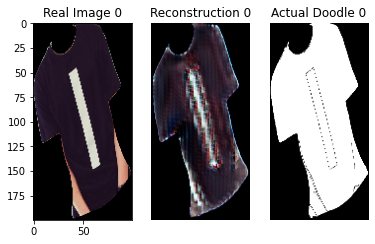

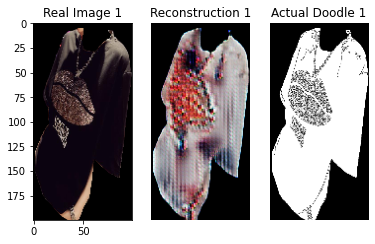

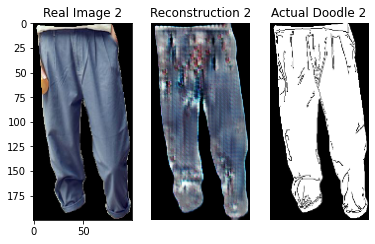

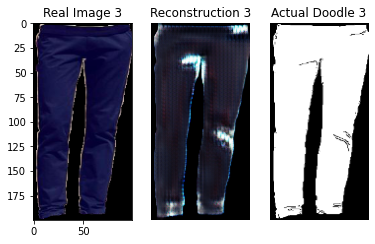

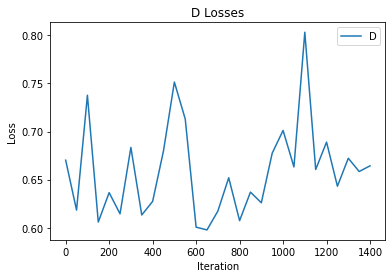

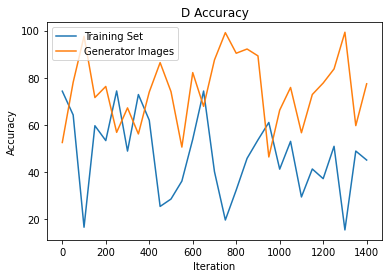

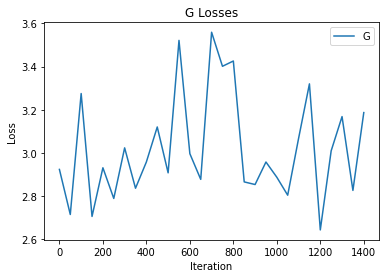

In [0]:
ne = 10
train(train_loader, generator, discriminator, optimizer_G, optimizer_D, bs, lr_g, lr_d, ne, lambda_l1)
epochs_trained += ne
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'epochs': epochs_trained
}, "Combined_GAN_ngf{}_nblocks{}_epochs{}_bs{}".format(ngf, n_blocks, epochs_trained, bs))

In [0]:
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'epochs': epochs_trained
}, "./drive/My Drive/University/APS360/APS360 Final Project/Zeng's Models/Combined_GAN_ngf{}_nblocks{}_epochs{}_bs{}".format(ngf, n_blocks, epochs_trained, bs))

In [0]:
generator

# Results

In [114]:
val_loader = get_data_loader(val_data_set, 1)

model_path = "GAN_ngf64_nblocks9_epochs140_bs64"
checkpoint = torch.load(model_path)

model_loaded = ResNetGenerator("Generator", 4, 4, 64, 9)
model_loaded.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

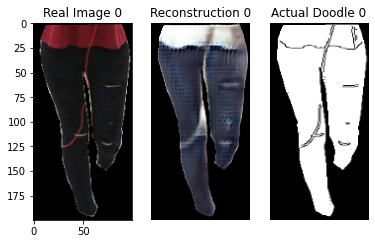

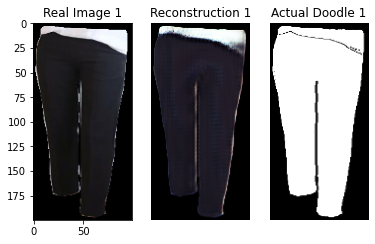

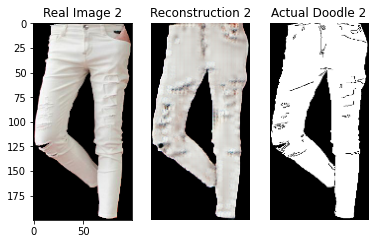

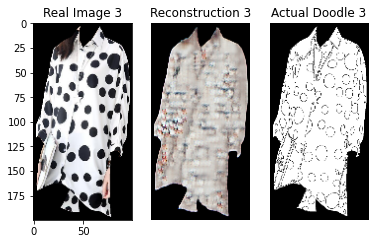

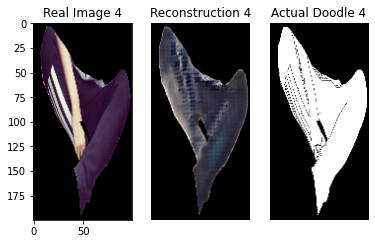

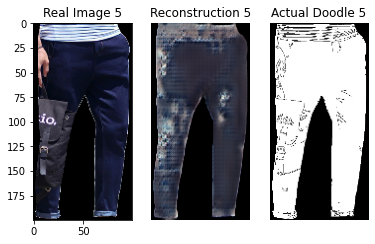

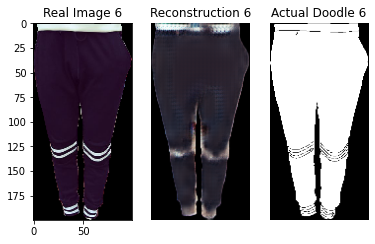

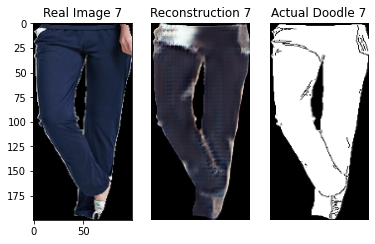

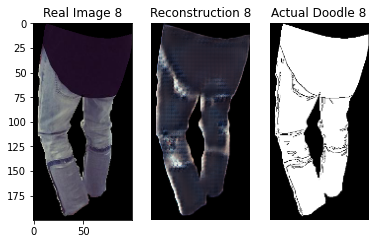

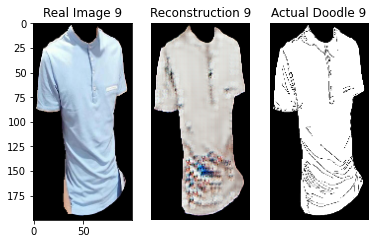

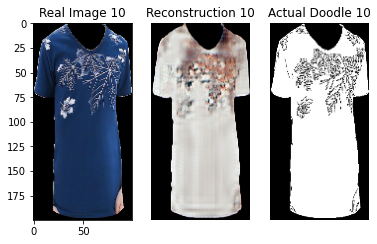

In [38]:
view_results(model_loaded, save_results=True)

In [54]:
plt.gcf()
plt.show()

<Figure size 432x288 with 0 Axes>

In [0]:
results_loader = get_data_loader(train_data_set, 1, shuffle=True)

In [124]:
view_results(model_loaded, results_loader, num_to_show=40, save_results=True)

Output hidden; open in https://colab.research.google.com to view.

In [81]:
get_accuracy(discriminator, generator, val_loader)

(75.59715945771465, 46.804389928986446)